## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 12 - Out-of-sample Testing**

In [15]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
import helper
import stats
import dask
from dask import compute, delayed


plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


In [16]:
from imp import reload  
reload(helper)
reload(stats)

<module 'stats' from 'e:\\My_Strategies_CTA\\stats.py'>

In [17]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [18]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[0] #随便取一个商品期货，可以更改
print(product)
all_dates = os.listdir(DATA_PATH + "\\" + product)
all_dates.sort()
n_days = len(all_dates)
print(len(all_dates), all_dates[:6])

rb
1063 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [19]:
period = 4096

# train and test
train_sample = np.array(all_dates) < "2019"
test_sample = np.array(all_dates) > "2019"
new_date = "20210507"
out_sample = np.array(all_dates)>=new_date

# 记录时间的字符串和时间格式
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


In [20]:
os.makedirs(HEAD_PATH+"\\all_signals", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [21]:
new_date = "20210507"
new_dates = np.array(all_dates)[np.array(all_dates)>=new_date]
new_dates.sort()
len(new_dates)

9

In [22]:
import sklearn.preprocessing

In [23]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

class factor_total_trade_imb_period(factor_template):
    factor_name = "total.trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)),1).values

class factor_trade_imb_period(factor_template):
    factor_name = "trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"]), period, adjust=True).values

from collections import OrderedDict
class factor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True))

from collections import OrderedDict
class factor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period).values
    
class factor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values
    
from collections import OrderedDict
class factor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

from collections import OrderedDict
class factor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

class factor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

class factor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True).values

class factor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).values

from collections import OrderedDict
class factor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))


from collections import OrderedDict
class factor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]
    
from collections import OrderedDict
class factor_volume_open_ratio_period(factor_template):
    factor_name = "volume.open.ratio.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(cum(data["qty"],period), cum(data["cum.open.int"]/period,period))

from collections import OrderedDict
class factor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

def get_atr(file, product, period_list, spread):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, SAVE_PATH+"\\factor_pkl\\"+product+"\\atr."+str(period) + "\\" + file[-12:])

class factor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

In [24]:
x1 = factor_trade_imb_period()
x2 = factor_total_trade_imb_period()
x3 = factor_nr_period()
x4 = factor_dbook_period()
x5 = factor_range_pos_period()
x6 = factor_price_osci_period()
x7 = factor_ma_diff_period()
x8 = factor_kdj_j_period()
x9 = factor_kdj_k_period()
x10 = factor_range_period()
x11 = factor_std_period()
x12 = factor_volume_open_ratio_period()
x13 = factor_trend_index_period()

In [25]:
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "volume.open.ratio", "trend.index"]
period_list = np.power(2, range(12,13))

In [26]:
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class factor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period"
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values
    xx = factor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = [DATA_PATH + "\\" + product+"\\"+date for date in date_list]
        parLapply(CORE_NUM, file_list, build_composite_signal, signal_list=xx, product=product, HEAD_PATH=HEAD_PATH)

In [27]:
%%time
i = 0
all_signal_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
for xx in all_signal_list:
    for product in product_list:
        print("signal ",i,product)
        build_composite_signal(DATA_PATH + "\\" + product+"\\"+"20210514.pkl",signal_list=xx, product=product, HEAD_PATH=SAVE_PATH)
    i = i + 1

signal  0 rb
signal  0 hc
signal  0 i
signal  0 j
signal  0 jm
signal  1 rb
signal  1 hc
signal  1 i
signal  1 j
signal  1 jm
signal  2 rb
signal  2 hc
signal  2 i
signal  2 j
signal  2 jm
signal  3 rb
signal  3 hc
signal  3 i
signal  3 j
signal  3 jm
signal  4 rb
signal  4 hc
signal  4 i
signal  4 j
signal  4 jm
signal  5 rb
signal  5 hc
signal  5 i
signal  5 j
signal  5 jm
signal  6 rb
signal  6 hc
signal  6 i
signal  6 j
signal  6 jm
signal  7 rb
signal  7 hc
signal  7 i
signal  7 j
signal  7 jm
signal  8 rb
signal  8 hc
signal  8 i
signal  8 j
signal  8 jm
signal  9 rb
signal  9 hc
signal  9 i
signal  9 j
signal  9 jm
signal  10 rb
signal  10 hc
signal  10 i
signal  10 j
signal  10 jm
signal  11 rb
signal  11 hc
signal  11 i
signal  11 j
signal  11 jm
signal  12 rb
signal  12 hc
signal  12 i
signal  12 j
signal  12 jm
Wall time: 6.74 s


In [28]:
%%time
i = 0
all_signal_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13]
for xx in all_signal_list:
    for product in product_list:
        print("signal ",i,product)
        file_list = list(map(lambda x: DATA_PATH + "\\" + product + "\\" + x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH)
    i = i + 1

signal  0 rb
signal  0 hc
signal  0 i
signal  0 j
signal  0 jm
signal  1 rb
signal  1 hc
signal  1 i
signal  1 j
signal  1 jm
signal  2 rb
signal  2 hc
signal  2 i
signal  2 j
signal  2 jm
signal  3 rb
signal  3 hc
signal  3 i
signal  3 j
signal  3 jm
signal  4 rb
signal  4 hc
signal  4 i
signal  4 j
signal  4 jm
signal  5 rb
signal  5 hc
signal  5 i
signal  5 j
signal  5 jm
signal  6 rb
signal  6 hc
signal  6 i
signal  6 j
signal  6 jm
signal  7 rb
signal  7 hc
signal  7 i
signal  7 j
signal  7 jm
signal  8 rb
signal  8 hc
signal  8 i
signal  8 j
signal  8 jm
signal  9 rb
signal  9 hc
signal  9 i
signal  9 j
signal  9 jm
signal  10 rb
signal  10 hc
signal  10 i
signal  10 j
signal  10 jm
signal  11 rb
signal  11 hc
signal  11 i
signal  11 j
signal  11 jm
signal  12 rb
signal  12 hc
signal  12 i
signal  12 j
signal  12 jm
Wall time: 4min 2s


In [29]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, ["20210514.pkl"], product_list, SAVE_PATH)

E:\My_Strategies_CTA\factor_pkl\rb\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\i\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\j\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\jm\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\rb\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\i\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\j\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\jm\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\rb\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\i\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\j\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\jm\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\rb\dbook.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\dbook.range.4096
E:\My_Strategies_CTA\factor_pkl\i\dbook.range.4096
E:\My_Strategies

In [30]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, new_dates, product_list, SAVE_PATH)

E:\My_Strategies_CTA\factor_pkl\rb\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\i\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\j\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\jm\trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\rb\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\i\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\j\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\jm\total.trade.imb.range.4096
E:\My_Strategies_CTA\factor_pkl\rb\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\i\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\j\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\jm\nr.range.4096
E:\My_Strategies_CTA\factor_pkl\rb\dbook.range.4096
E:\My_Strategies_CTA\factor_pkl\hc\dbook.range.4096
E:\My_Strategies_CTA\factor_pkl\i\dbook.range.4096
E:\My_Strategies

In [31]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH + "\\" + product + "\\" + x, new_dates))
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(12,13)), spread=spread) 

Wall time: 9.92 s


In [32]:
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [33]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH +"\\"+ product)))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"\\daily_num\\"+product+".pkl")

Wall time: 1min 36s


In [38]:
def par_get_signal_mat(file_name, product, signal_list, HEAD_PATH, SAVE_PATH):
    signal_mat = functools.reduce(functools.partial(get_signal_mat, product=product, file_name=file_name, HEAD_PATH=SAVE_PATH), signal_list, None)
    save(signal_mat, SAVE_PATH+"\\signal_mat_pkl\\"+product+"\\"+file_name)

In [39]:
%%time
for product in product_list:
    print(product)
    par_get_signal_mat("20210514.pkl", product=product, signal_list=signal_list, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 3.95 s


In [40]:
%%time
for product in product_list:
    print(product)
    parLapply(CORE_NUM, new_dates, par_get_signal_mat, 
              product=product, signal_list=signal_list, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 41.2 s


In [41]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".002"

In [42]:
ori_mat = load(HEAD_PATH+"\\train_test_mat\\"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [43]:
train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in ["hc","j","jm"]:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

rb (4809, 48)
hc (4208, 48)
j (3639, 48)
jm (3403, 48)


In [44]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [45]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = model.coef_/x_std
print(fit_coef)

[-0.         -0.          0.01293634 -0.02785023 -0.00103634  0.02294916
  0.          0.         -0.         -0.         -0.          0.
 -0.         -0.00264385  0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.         -0.          0.
 -0.         -0.0360791   0.          0.          0.         -0.
 -0.00874175 -0.          0.         -0.         -0.          0.00712943
  0.          0.         -0.        ]


In [46]:
coef_list=dict([])
for product in ["rb","hc","j","jm"]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef)

rb
trade.imb.4096                           -0.000000
total.trade.imb.4096                     -0.000000
nr.4096                                   0.002510
dbook.4096                               -0.002366
range.pos.4096                           -0.000040
price.osci.4096                           0.000227
ma.dif.10.4096                            0.000000
kdj.k.4096                                0.000000
kdj.j.4096                               -0.000000
trade.imb.range.4096                     -0.000000
total.trade.imb.range.4096               -0.000000
nr.range.4096                             0.000000
dbook.range.4096                         -0.000000
range.pos.range.4096                     -0.000003
price.osci.range.4096                     0.000000
ma.dif.10.range.4096                      0.000000
kdj.k.range.4096                          0.000000
kdj.j.range.4096                         -0.000000
trade.imb.std.4096                       -0.000000
total.trade.imb.std.4096    

In [47]:
product = "i"
train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
coef = model.coef_/x_std
print(product)
print(coef)
coef_list[product] = coef

i
[ 2.62562922e-03 -2.35174568e-03  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  6.21697879e-04 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  7.65726125e-04
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  8.37570052e-06  0.00000000e+00 -0.00000000e+00  1.45898065e-04
  0.00000000e+00 -7.34670201e-04 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.85690660e-01 -0.00000000e+00 -1.11930653e-03
  5.55411291e-05  0.00000000e+00  3.28433705e-03  7.00288861e-04
 -2.68733801e-03  1.26014932e-04  0.00000000e+00  3.98545332e-04
 -0.00000000e+00]


In [48]:
strat = "overall.lasso.002."+str(period)
for product in product_list:
    os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat, exist_ok=True)

In [66]:
new_dates

array(['20210507.pkl', '20210514.pkl', '20210517.pkl', '20210518.pkl',
       '20210519.pkl', '20210520.pkl', '20210521.pkl', '20210524.pkl',
       '20210525.pkl'], dtype='<U12')

In [59]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, new_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 19.8 s


In [60]:
for product in product_list:
    coef = coef_list[product]
    par_get_daily_pred("20210514.pkl",
        product=product, coef=coef, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

In [61]:
%%time
product = "i"
coef = coef_list[product]
result = parLapply(CORE_NUM, new_dates, par_get_daily_pred, 
    product=product, coef=coef, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

Wall time: 3.62 s


In [62]:
def get_good(date, product, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+date)
    good = data["good"]
    save(good, SAVE_PATH+"\\good_pkl\\"+product+"\\"+date)  

In [63]:
%%time
for product in product_list:
    print(product)
    parLapply(CORE_NUM, new_dates, get_good, product=product, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

rb
hc
i
j
jm
Wall time: 10.8 s


In [64]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH=SAVE_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\My_Strategies_CTA\\factor_pkl\\i\\overall.lasso.002.4096\\20170103.pkl'

In [65]:
signal = "overall.lasso.002"
product = "i"
period = 4096
SIGNAL_PATH = SAVE_PATH
signal_name = signal+"."+str(period)
all_signal = load(SIGNAL_PATH+"\\all_signals\\"+product+"."+signal_name+".pkl")
tranct = product_info[product]["tranct"]
tranct_ratio = product_info[product]["tranct.ratio"]
open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\My_Strategies_CTA\\all_signals\\i.overall.lasso.002.4096.pkl'

In [ ]:
%%time
for product in product_list:
    print(product)
    spread = product_info[product]["spread"]
    evaluate_signal("overall.lasso.002", np.array(all_dates), product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2019", tranct=1.1e-4, 
                    max_spread=spread*1.1, tranct_ratio=True, atr_filter=0.01, save_path="signal_result_atr",reverse=1)

rb train sharpe  0.15871188774199899 test sharpe  0.326056896848912
hc train sharpe  0.38052252598063396 test sharpe  0.004471418524921818
i train sharpe  0.719225737312588 test sharpe  -0.8752812864853308
j train sharpe  0.4138635275391852 test sharpe  1.010661657729218
jm train sharpe  0.5112382790838763 test sharpe  -0.7491906653433114
train sharpe:  0.7114556723582379 test sharpe:  -0.3160581734667816


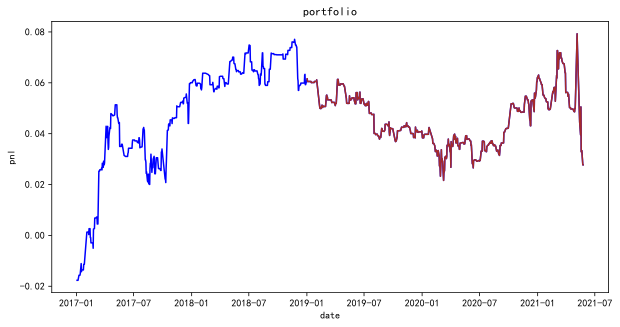

In [78]:
i = 0
strat = "overall.lasso.002.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 1
min_num = 5
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"\\signal_result_atr\\"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)>0:
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(10, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color="b")
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color="brown")
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio)) 

sharpe  -2.241659458620189


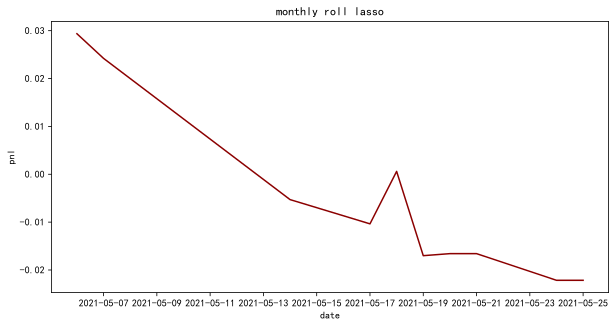

In [79]:
new_sample = np.array(all_dates) >= "20210506"
out_pnl =  all_portfolio[new_sample]
plt.figure(1, figsize=(10, 5))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[new_sample], out_pnl.cumsum(), color="darkred")
print("sharpe ", sharpe(out_pnl))

In [80]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal_result_atr", HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH):
    start_month = 0
    end_month = sum(month_len[0] < "2019")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"\\all_signals\\"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                             max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"\\"+save_path+"\\"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [69]:
month = np.array([file[:6] for file in all_dates])
month_len = np.unique(month, return_counts=True)
month_len

(array(['201701', '201702', '201703', '201704', '201705', '201706',
        '201707', '201708', '201709', '201710', '201711', '201712',
        '201801', '201802', '201803', '201804', '201805', '201806',
        '201807', '201808', '201809', '201810', '201811', '201812',
        '201901', '201902', '201903', '201904', '201905', '201906',
        '201907', '201908', '201909', '201910', '201911', '201912',
        '202001', '202002', '202003', '202004', '202005', '202006',
        '202007', '202008', '202009', '202010', '202011', '202012',
        '202101', '202102', '202103', '202104', '202105'], dtype='<U6'),
 array([18, 18, 23, 18, 20, 22, 21, 23, 21, 17, 22, 21, 22, 15, 22, 18, 22,
        20, 22, 23, 19, 18, 22, 20, 22, 15, 21, 21, 20, 19, 23, 22, 20, 18,
        21, 22, 16, 20, 22, 21, 18, 20, 23, 21, 22, 16, 21, 23, 20, 15, 23,
        21, 10], dtype=int64))

In [81]:
test_range = month_len[0] >= "2019"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
cum_month_len = np.cumsum(month_len[1])
month_len[1][test_range]

array([22, 15, 21, 21, 20, 19, 23, 22, 20, 18, 21, 22, 16, 20, 22, 21, 18,
       20, 23, 21, 22, 16, 21, 23, 20, 15, 23, 21, 10], dtype=int64)

In [83]:
new_start = np.where(month_len[0]>="20210506")[0]
new_start

array([], dtype=int64)

In [ ]:
month_len[0][test_range]

In [ ]:
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample])
    n_days = sum(sample)
    n_signal = len(signal_list)
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        chosen = (np.arange(sum(data["good"]))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
            S = S[data["good"]]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [ ]:
class factor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
    
y1 = factor_ret_period()
class factor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
    
y2 = factor_ret_period_002()
class factor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
    
y3 = factor_ret_period_001()

In [ ]:
%%time
i = 0
all_pred_list = [y1,y2,y3]
for xx in all_pred_list:
    for product in product_list:
        print("pred ",i,product)
        file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH)
    i = i + 1

In [ ]:
np.sum(out_sample)

In [ ]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    out_mat = get_sample_signal(all_dates, out_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002"]), 
                                  period, daily_num)
    save(out_mat, HEAD_PATH+"\\train_test_mat\\"+product+".out.mat.pkl")

In [ ]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"\\daily_num\\"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".train.mat.pkl")
    out_mat = load(HEAD_PATH+"\\train_test_mat\\"+product+".out.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [ ]:
from sklearn.preprocessing import StandardScaler

test_range = np.where(month_len[0] > "2019")[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2019")-1
cum_month_len = np.cumsum(month_len[1])

In [ ]:
month_len

In [ ]:
test_range

In [ ]:
new_start

In [ ]:
%%time
strat = "universal.lasso.002.4096"
y_signal = "ret.4096.002"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        get_multiple_lasso_roll_model(train_start, train_end, y_signal, n_signal, daily_ticks, all_mat, forward_len, strat+"."+month_len[0][i_test], 
                              ["i"], ["rb","hc","j","jm"], period=4096, SAVE_PATH=SAVE_PATH)
    start_month = start_month+1
    end_month = end_month+1

In [ ]:
%%time
start_month = 0
strat_name = "universal.lasso.002.4096"
end_month = sum(month_len[0] < "2019")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        strat_name = strat+"."+month_len[0][i_test]
        coef_list = load(SAVE_PATH+"\\models\\"+strat_name+".pkl")
        for product in product_list:
            coef = coef_list[product]
            os.makedirs(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+strat_name, exist_ok=True)
            parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                      product=product, coef=coef, strat=strat_name, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)
    start_month = start_month+1
    end_month = end_month+1

In [70]:
month_len[0]

array(['201701', '201702', '201703', '201704', '201705', '201706',
       '201707', '201708', '201709', '201710', '201711', '201712',
       '201801', '201802', '201803', '201804', '201805', '201806',
       '201807', '201808', '201809', '201810', '201811', '201812',
       '201901', '201902', '201903', '201904', '201905', '201906',
       '201907', '201908', '201909', '201910', '201911', '201912',
       '202001', '202002', '202003', '202004', '202005', '202006',
       '202007', '202008', '202009', '202010', '202011', '202012',
       '202101', '202102', '202103', '202104', '202105'], dtype='<U6')

In [ ]:
%%time
strat = "universal.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    if i_test>=new_start:
        for product in product_list:
            par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, 
                               SAVE_PATH = SAVE_PATH)
    start_month = start_month+1
    end_month = end_month+1

In [ ]:
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal_result_atr", HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH):
    start_month = 0
    end_month = sum(month_len[0] < "2019")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        if i_test>=new_start:
            all_signal = load(SIGNAL_PATH+"\\all_signals\\"+product+"."+strat_name+".pkl")
            open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
            thre_list = []
            for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
                thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
            thre_list = np.array(thre_list)
            thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
            train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                                 product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                                 max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
            test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                                product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=1.1e-4, 
                                 max_spread=spread+0.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            test_stat = get_hft_summary(test_result, thre_mat, forward_len)
            stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
            save(stat_result, HEAD_PATH+"\\"+save_path+"\\"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [ ]:
%%time
strat = "universal.lasso.002.4096"
for product in product_list:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=0.01)

In [ ]:
test_range

In [ ]:
n_product = len(product_list)
save_path = "signal result atr"
strat = "universal.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"\\"+save_path+"\\"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        if (i_product==0):
            test_mat = np.zeros((len(test_pnl), n_product))
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    avg_test_pnl = test_mat.mean(axis=1)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
out_pnl = all_pnl[-sum(out_sample):]
plt.figure(1, figsize=(10, 5))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(format_dates[out_sample], out_pnl.cumsum(), color="darkred")
print("sharpe ", sharpe(out_pnl))

In [ ]:
n_product = len(product_list)
test_range = np.where(month_len[0] >= "2019")[0]
save_path = "signal result atr"
strat = "universal.lasso.002.4096"
start_month = 0
end_month = sum(month_len[0] < "2019")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"\\"+save_path+"\\"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        if i_product ==0:
            test_mat = np.zeros((len(test_pnl), n_product))
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    avg_test_pnl = test_mat.mean(axis=1)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
out_pnl = all_pnl
plt.figure(1, figsize=(10, 5))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(out_pnl.cumsum(), color="darkred")
print("sharpe ", sharpe(out_pnl))